### Descargamos el archivo log

In [3]:
import kagglehub # pip install kagglehub

In [4]:
path = kagglehub.dataset_download("eliasdabbas/web-server-access-logs")

100%|██████████| 267M/267M [00:11<00:00, 23.4MB/s] 

Extracting files...


In [5]:
print("Path to dataset files:", path)

Path to dataset files: /home/jovyan/.cache/kagglehub/datasets/eliasdabbas/web-server-access-logs/versions/2


### Empezamos a limpiar el archivo log

In [1]:
# Importamos bibliotecas
import numpy as np
import pandas as pd
from datetime import datetime
import re
from sklearn.ensemble import IsolationForest

# Establecemos las columnas
colz=["IP","timestamp","method","URL","protocol","status code","bytes sent","user agent"]

li=[]
c=0

# Abrimos el archivo
with open("logs/access.log") as f:
    while(True):
        if(c==2000000):
            break
        if(c%100000==0):
            print(c) # Esto nose, yo lo borraria
        try:
            x=f.readline()
            if x==None:
                break
            log=x.split(" ")
            if(len(log)<12):
                continue
            #print([log[0],log[3].strip('['),log[5].strip('"'),log[7].strip('"'),int(log[8]),int(log[9]),' '.join(log[11:-1]).strip('"')])
            li.append([log[0],log[3].strip('['),log[5].strip('"'),log[6],log[7].strip('"'),int(log[8]),int(log[9]),' '.join(log[11:-1]).strip('"')])
        except Exception as e:
            pass
            #print(e)
            #print(log)
            #print(int(log[8]),int(log[9]))
            #print("skipped an entry")
        c+=1

# basic feature engineering
logs_df=pd.DataFrame(li,columns=colz)
logs_df["timestamp"]=pd.to_datetime(logs_df["timestamp"],format='%d/%b/%Y:%H:%M:%S')


logs_df["url_length"]=logs_df["URL"].apply(len)
logs_df["url_depth"]=logs_df["URL"].apply(lambda x : x.count('/'))
logs_df['num_encoded_chars'] = logs_df['URL'].apply(lambda x: len(re.findall(r'%[0-9A-Fa-f]{2}', x)))
logs_df['num_special_chars'] = logs_df['URL'].apply(lambda x: len(re.findall(r'[|,;]', x)))

0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000
1800000
1900000


In [2]:
# Verificamos valores nulos
logs_df.isnull().sum()

IP                   0
timestamp            0
method               0
URL                  0
protocol             0
status code          0
bytes sent           0
user agent           0
url_length           0
url_depth            0
num_encoded_chars    0
num_special_chars    0
dtype: int64

In [3]:
# Mostramos las primeras filas
logs_df.head(5)

,IP,timestamp,method,URL,protocol,status code,bytes sent,user agent,url_length,url_depth,num_encoded_chars,num_special_chars
0,54.36.149.41,2019-01-22 03:56:14,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,HTTP/1.1,200,30577,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,166,2,48,4
1,31.56.96.51,2019-01-22 03:56:16,GET,/image/60844/productModel/200x200,HTTP/1.1,200,5667,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,33,4,0,0
2,31.56.96.51,2019-01-22 03:56:16,GET,/image/61474/productModel/200x200,HTTP/1.1,200,5379,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,33,4,0,0
3,40.77.167.129,2019-01-22 03:56:17,GET,/image/14925/productModel/100x100,HTTP/1.1,200,1696,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,33,4,0,0
4,91.99.72.15,2019-01-22 03:56:17,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,HTTP/1.1,200,41483,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,146,4,38,0


In [4]:
cuentas = logs_df.value_counts(["bytes sent"])
print(cuentas)

bytes sent
0             135322
4120           62694
11             53348
28536          24314
323            24281
               ...  
30419              1
30431              1
30468              1
30471              1
1249490            1
Name: count, Length: 47687, dtype: int64


In [5]:
# Vemos los datos del tiempo
logs_df["timestamp"]

0         2019-01-22 03:56:14
1         2019-01-22 03:56:16
2         2019-01-22 03:56:16
3         2019-01-22 03:56:17
4         2019-01-22 03:56:17
                  ...        
1999965   2019-01-22 22:28:47
1999966   2019-01-22 22:28:47
1999967   2019-01-22 22:28:47
1999968   2019-01-22 22:28:48
1999969   2019-01-22 22:28:48
Name: timestamp, Length: 1999970, dtype: datetime64[ns]

In [6]:
# Vemos las dimensiones del dataframe
logs_df.shape

(1999970, 12)

In [7]:
# Vemos los datos de "user agent"
logs_df["user agent"]

0          Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1          Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2          Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3          Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4          Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
                                 ...                        
1999965    Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
1999966    Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...
1999967    Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
1999968    Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
1999969    Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
Name: user agent, Length: 1999970, dtype: object

In [8]:
# Vemos los primeros 6 valores de "user agent"
for x in range(6):
    print(logs_df["user agent"][x])

Mozilla/5.0 (compatible; AhrefsBot/6.1; +http://ahrefs.com/robot/)
Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36
Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build/HuaweiALE-L21) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/66.0.3359.158 Mobile Safari/537.36
Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)
Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16.0)Gecko/16.0 Firefox/16.0
Mozilla/5.0 (compatible; bingbot/2.0; +http://www.bing.com/bingbot.htm)


In [9]:
# Renombramos la variable
user_agents = logs_df["user agent"].tolist()
#user_agents

/tmp/ipykernel_159/3365663316.py:45: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Cantidad', y='Categoria', data=df_conteo, palette='viridis')


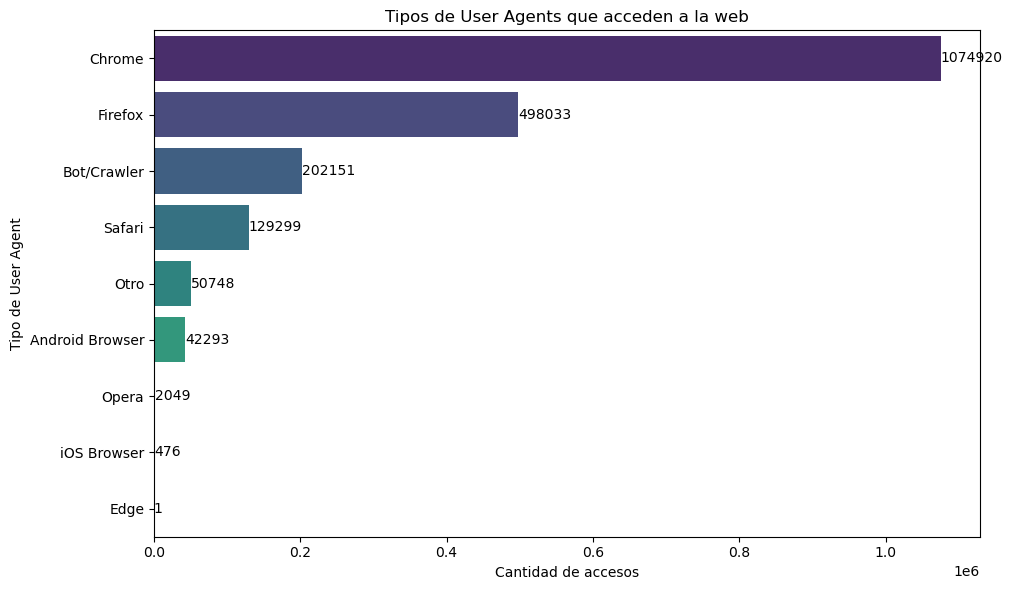

In [10]:
# Importamos bibliotecas
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import re

# Renombramos la variable
user_agents = logs_df["user agent"].tolist()

# Función para categorizar user agents
def categorizar_user_agent(ua):
    ua = ua.lower()
    if 'bot' in ua or 'crawler' in ua or 'spider' in ua or 'ahrefs' in ua or 'bing' in ua:
        return 'Bot/Crawler'
    elif 'chrome' in ua:
        return 'Chrome'
    elif 'firefox' in ua:
        return 'Firefox'
    elif 'safari' in ua and 'chrome' not in ua:
        return 'Safari'
    elif 'edge' in ua or 'edg/' in ua:
        return 'Edge'
    elif 'opera' in ua:
        return 'Opera'
    elif 'android' in ua:
        return 'Android Browser'
    elif 'iphone' in ua or 'ipad' in ua:
        return 'iOS Browser'
    else:
        return 'Otro'

# Aplicar categorización
categorias = [categorizar_user_agent(ua) for ua in user_agents]

# Contar frecuencia
conteo = Counter(categorias)

# Crear DataFrame para el gráfico
df_conteo = pd.DataFrame.from_dict(conteo, orient='index').reset_index()
df_conteo.columns = ['Categoria', 'Cantidad']
df_conteo = df_conteo.sort_values('Cantidad', ascending=False)

# Crear gráfico de barras
plt.figure(figsize=(10, 6))
sns.barplot(x='Cantidad', y='Categoria', data=df_conteo, palette='viridis')
plt.title('Tipos de User Agents que acceden a la web')
plt.xlabel('Cantidad de accesos')
plt.ylabel('Tipo de User Agent')
plt.tight_layout()

# Mostrar valores en las barras
for i, valor in enumerate(df_conteo['Cantidad']):
    plt.text(valor + 0.1, i, str(valor), va='center')

plt.show()

In [11]:
aux = logs_df["IP"]
aux

0             54.36.149.41
1              31.56.96.51
2              31.56.96.51
3            40.77.167.129
4              91.99.72.15
                ...       
1999965      5.134.191.194
1999966    151.235.247.222
1999967      5.134.191.194
1999968       5.112.45.203
1999969       5.112.45.203
Name: IP, Length: 1999970, dtype: object

In [12]:
logs_df['IP'] = logs_df['IP'].astype(str).str.strip()

In [13]:
aux2 = aux.unique()
len(aux2)

50910

In [14]:
from tqdm import tqdm
import geoip2.database

reader = geoip2.database.Reader('GeoLite2-City.mmdb')

print("Geolocalizando IPs...")
countries, cities, latitudes, longitudes = [], [], [], []

for ip in tqdm(logs_df['IP']):
    try:
        response = reader.city(ip)
        countries.append(response.country.name or 'Privada/Local')
        cities.append(response.city.name or 'Privada/Local')
        latitudes.append(response.location.latitude if response.location.latitude else None)
        longitudes.append(response.location.longitude if response.location.longitude else None)
    except:
        countries.append('Privada/Local')
        cities.append('Privada/Local')
        latitudes.append(None)
        longitudes.append(None)

logs_df['country'] = countries
logs_df['city'] = cities
logs_df['latitude'] = latitudes
logs_df['longitude'] = longitudes

reader.close()

print("¡Geolocalización completada!")
print(logs_df[['IP', 'country', 'city', 'latitude', 'longitude']].head())


Geolocalizando IPs...


100%|██████████| 1999970/1999970 [02:01<00:00, 16402.92it/s]


¡Geolocalización completada!
              IP          country           city  latitude  longitude
0   54.36.149.41           France  Privada/Local   48.8582     2.3387
1    31.56.96.51  The Netherlands      Amsterdam   52.3759     4.8975
2    31.56.96.51  The Netherlands      Amsterdam   52.3759     4.8975
3  40.77.167.129    United States        Boydton   36.6694   -78.3877
4    91.99.72.15          Germany      Nuremberg   49.4527    11.0783


In [16]:
logs_df

,IP,timestamp,method,URL,protocol,status code,bytes sent,user agent,url_length,url_depth,num_encoded_chars,num_special_chars,country,city,latitude,longitude
0,54.36.149.41,2019-01-22 03:56:14,GET,/filter/27|13%20%D9%85%DA%AF%D8%A7%D9%BE%DB%8C...,HTTP/1.1,200,30577,Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...,166,2,48,4,France,Privada/Local,48.8582,2.3387
1,31.56.96.51,2019-01-22 03:56:16,GET,/image/60844/productModel/200x200,HTTP/1.1,200,5667,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,33,4,0,0,The Netherlands,Amsterdam,52.3759,4.8975
2,31.56.96.51,2019-01-22 03:56:16,GET,/image/61474/productModel/200x200,HTTP/1.1,200,5379,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,33,4,0,0,The Netherlands,Amsterdam,52.3759,4.8975
3,40.77.167.129,2019-01-22 03:56:17,GET,/image/14925/productModel/100x100,HTTP/1.1,200,1696,Mozilla/5.0 (compatible; bingbot/2.0; +http://...,33,4,0,0,United States,Boydton,36.6694,-78.3877
4,91.99.72.15,2019-01-22 03:56:17,GET,/product/31893/62100/%D8%B3%D8%B4%D9%88%D8%A7%...,HTTP/1.1,200,41483,Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...,146,4,38,0,Germany,Nuremberg,49.4527,11.0783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1999965,5.134.191.194,2019-01-22 22:28:47,GET,/settings/logo,HTTP/1.1,200,4120,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,14,2,0,0,Iran,Privada/Local,35.6980,51.4115
1999966,151.235.247.222,2019-01-22 22:28:47,GET,/static/css/font/wyekan/font.woff,HTTP/1.1,200,28536,Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...,33,5,0,0,Iran,Privada/Local,35.6980,51.4115
1999967,5.134.191.194,2019-01-22 22:28:47,GET,/static/images/amp/blog.png,HTTP/1.1,200,3863,Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...,27,4,0,0,Iran,Privada/Local,35.6980,51.4115
1999968,5.112.45.203,2019-01-22 22:28:48,GET,/image/33618/productType/120x90,HTTP/1.1,200,10695,Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...,31,4,0,0,Iran,Privada/Local,35.6980,51.4115


In [19]:
from tqdm import tqdm

# Usar la base de datos
import geoip2.database
reader = geoip2.database.Reader('GeoLite2-City.mmdb')

print("Geolocalizando IPs...")
countries, cities = [], []

for ip in tqdm(logs_df['IP']):
    try:
        response = reader.city(ip)
        countries.append(response.country.name)
        cities.append(response.city.name or 'Privada/Local')
    except:
        countries.append('Privada/Local')
        cities.append('Privada/Local')

logs_df['country'] = countries
logs_df['city'] = cities

reader.close()

print("¡Geolocalización completada!")
print(logs_df[['IP', 'country', 'city']].head())

Geolocalizando IPs...


100%|██████████| 1999970/1999970 [01:58<00:00, 16869.57it/s]


¡Geolocalización completada!
              IP          country           city
0   54.36.149.41           France  Privada/Local
1    31.56.96.51  The Netherlands      Amsterdam
2    31.56.96.51  The Netherlands      Amsterdam
3  40.77.167.129    United States        Boydton
4    91.99.72.15          Germany      Nuremberg


## NUEVO CODIGO

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import re
from ua_parser import user_agent_parser
from sqlalchemy import create_engine
from Modulos.update_dimensions_table import actualizarTablaDimension

In [2]:
def process_log_file(filepath, chunk_size=100000):
    colz = ["IP", "timestamp", "status code", "bytes sent", "user agent"]
    all_chunks = []
    
    with open(filepath, 'r') as f:
        lines_processed = 0
        while True:
            li = []
            # Procesar chunk
            for _ in range(chunk_size):
                try:
                    x = f.readline()
                    if not x:  # EOF
                        break
                    log = x.split(" ")
                    if len(log) < 12:
                        continue
                    li.append([log[0], log[3].strip('['), int(log[8]), int(log[9]), ' '.join(log[11:-1]).strip('"')])
                except Exception as e:
                    continue
            
            if not li:  # No más datos
                break
                
            # Crear DataFrame del chunk
            chunk_df = pd.DataFrame(li, columns=colz)
            chunk_df["timestamp"] = pd.to_datetime(chunk_df["timestamp"], format='%d/%b/%Y:%H:%M:%S')
            all_chunks.append(chunk_df)
            
            lines_processed += len(li)
            print(f"Procesadas {lines_processed} líneas...")
    
    # Combinar todos los chunks
    if all_chunks:
        logs_df = pd.concat(all_chunks, ignore_index=True)
        return logs_df
    else:
        return pd.DataFrame(columns=colz)

# Uso
filepath = "logs/access_ssl_20230404.log"
print("Procesando archivo de logs...")
logs_df = process_log_file(filepath, chunk_size=1000000)
print("Procesamiento completado")
print(logs_df.info())

Procesando archivo de logs...
Procesadas 999958 líneas...
Procesadas 1999910 líneas...
Procesadas 2539378 líneas...
Procesamiento completado
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2539378 entries, 0 to 2539377
Data columns (total 5 columns):
 #   Column       Dtype         
---  ------       -----         
 0   IP           object        
 1   timestamp    datetime64[ns]
 2   status code  int64         
 3   bytes sent   int64         
 4   user agent   object        
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 96.9+ MB
None


In [4]:
logs_df.tail()

,IP,timestamp,status code,bytes sent,user agent
2539373,40.77.167.190,2023-04-04 03:39:55,200,49881,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge..."
2539374,40.77.167.190,2023-04-04 03:41:07,200,10244,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge..."
2539375,173.252.83.17,2023-04-04 03:47:24,200,751355,facebookexternalhit/1.1
2539376,207.46.13.213,2023-04-04 03:50:49,304,0,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge..."
2539377,66.249.64.94,2023-04-04 03:51:25,200,174576,Mozilla/5.0 (Linux; Android 6.0.1; Nexus 5X Bu...


In [12]:
logs_df.head()

,IP,timestamp,status code,bytes sent,user agent
0,35.237.235.186,2023-01-29 03:50:28,404,1391,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...
1,75.101.236.114,2023-01-29 03:50:45,403,747,
2,45.173.1.108,2023-01-29 03:50:48,200,435,WordPress/6.1.1;
3,54.174.104.52,2023-01-29 03:50:50,200,907,
4,34.205.37.78,2023-01-29 03:50:51,200,792426,


In [13]:
logs_df['timestamp'] = pd.to_datetime(logs_df['timestamp']) #lo convertiamos a datatime

#Sacamos dia,mes y año
logs_df['dia'] = logs_df['timestamp'].dt.day
logs_df['mes'] = logs_df['timestamp'].dt.month
logs_df['año'] = logs_df['timestamp'].dt.year
#logs_df['hora'] = logs_df['timestamp'].dt.hour

In [12]:
logs_df

,IP,timestamp,status code,bytes sent,user agent,dia,mes,año,hora
0,35.237.235.186,2023-01-29 03:50:28,404,1391,Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/53...,29,1,2023,3
1,75.101.236.114,2023-01-29 03:50:45,403,747,,29,1,2023,3
2,45.173.1.108,2023-01-29 03:50:48,200,435,WordPress/6.1.1;,29,1,2023,3
3,54.174.104.52,2023-01-29 03:50:50,200,907,,29,1,2023,3
4,34.205.37.78,2023-01-29 03:50:51,200,792426,,29,1,2023,3
...,...,...,...,...,...,...,...,...,...
2539373,40.77.167.190,2023-04-04 03:39:55,200,49881,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",4,4,2023,3
2539374,40.77.167.190,2023-04-04 03:41:07,200,10244,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",4,4,2023,3
2539375,173.252.83.17,2023-04-04 03:47:24,200,751355,facebookexternalhit/1.1,4,4,2023,3
2539376,207.46.13.213,2023-04-04 03:50:49,304,0,"Mozilla/5.0 AppleWebKit/537.36 (KHTML, like Ge...",4,4,2023,3


In [ ]:
#solo de revisar

In [ ]:
contador = 0
for x in range(10000):
    print(logs_df["country"][x])
    contador +=1
    if contador == 100:
        break

In [28]:
# Filtrar las IPs que quedaron como "Desconocido" en país o ciudad
desconocidas = logs_df[(logs_df['country'] == 'Privada/Local') | 
                       (logs_df['city'] == 'Privada/Local')]

print(f"Total desconocidas: {len(desconocidas)}")

# Mostrar algunas filas
print(desconocidas[['IP', 'country', 'city']].head(90))

# Si querés guardar todas en un CSV para revisar
desconocidas[['IP', 'country', 'city']].to_csv('ips_desconocidas.csv', index=False)


Total desconocidas: 1395941
                IP        country           city
0     54.36.149.41         France  Privada/Local
8    66.249.66.194  United States  Privada/Local
10   207.46.13.136  United States  Privada/Local
16   207.46.13.136  United States  Privada/Local
19   66.249.66.194  United States  Privada/Local
..             ...            ...            ...
172  66.249.66.194  United States  Privada/Local
173  157.55.39.245  United States  Privada/Local
180  207.46.13.136  United States  Privada/Local
182  66.249.66.194  United States  Privada/Local
183  157.55.39.245  United States  Privada/Local

[90 rows x 3 columns]


In [12]:
#OPCIONAL









from tqdm import tqdm
import geoip2.database
import pandas as pd
import ipaddress
import shelve  # opcional para persistir cache entre ejecuciones

# ejemplo: logs_df ya existe y tiene columna 'IP'
# logs_df = pd.read_csv('...')  # si fuera necesario

DB_PATH = 'GeoLite2-City.mmdb'
USE_SHELVE_CACHE = False  # poner True si querés guardar cache en disco entre ejecuciones
SHELVE_PATH = 'ip_geo_cache.db'

reader = geoip2.database.Reader(DB_PATH)

# --- Opcional: cargar cache persistente ---
if USE_SHELVE_CACHE:
    cache = shelve.open(SHELVE_PATH)
    ip_geo = dict(cache)  # cargar en memoria para acceso rápido
else:
    ip_geo = {}

# Obtener IPs únicas que no estén en cache
unique_ips = set(logs_df['IP'].unique())
ips_to_lookup = [ip for ip in unique_ips if ip not in ip_geo]

print(f"IPs únicas: {len(unique_ips)}. A geolocalizar (no cacheadas): {len(ips_to_lookup)}")

for ip in tqdm(ips_to_lookup, desc="Geolocalizando IPs únicas"):
    try:
        # evitar hacer lookup en IPs privadas/reservadas
        try:
            if ipaddress.ip_address(ip).is_private:
                ip_geo[ip] = {'country': 'Privada/Local', 'city': 'Privada/Local'}
                continue
        except ValueError:
            # ip no válida
            ip_geo[ip] = {'country': 'Inválida', 'city': 'Inválida'}
            continue

        response = reader.city(ip)
        country = response.country.name or 'Desconocido'
        city = (response.city.name or 'Desconocido')
        ip_geo[ip] = {'country': country, 'city': city}
    except Exception:
        ip_geo[ip] = {'country': 'Desconocido', 'city': 'Desconocido'}

# --- Opcional: guardar cache persistente ---
if USE_SHELVE_CACHE:
    # sobreescribir shelve con ip_geo
    for k, v in ip_geo.items():
        cache[k] = v
    cache.close()

reader.close()


# Mapear al DataFrame (forma eficiente)
# Crear Series para country y city usando map con el diccionario
logs_df['country'] = logs_df['IP'].map(lambda ip: ip_geo.get(ip, {}).get('country', 'Desconocido'))
logs_df['city']    = logs_df['IP'].map(lambda ip: ip_geo.get(ip, {}).get('city', 'Desconocido'))

print("Geolocalización completada.")
print(logs_df[['IP', 'country', 'city']].head())


IPs únicas: 50910. A geolocalizar (no cacheadas): 50910


Geolocalizando IPs únicas: 100%|██████████| 50910/50910 [00:06<00:00, 7698.80it/s]


Geolocalización completada.
              IP          country         city
0   54.36.149.41           France  Desconocido
1    31.56.96.51  The Netherlands    Amsterdam
2    31.56.96.51  The Netherlands    Amsterdam
3  40.77.167.129    United States      Boydton
4    91.99.72.15          Germany    Nuremberg


In [ ]:
import requests
import time
#https://ip-api.com/
def ip_to_country_api(ip):
    try:
        response = requests.get(f'http://ip-api.com/json/{ip}?fields=country,city') #cambiar por Country o City
        data = response.json()
        return data.get("city")
    except:
        return 'Desconocido'
    
    # Esperar 1 segundo para no saturar la API (límite de 45 requests/minuto)
    time.sleep(1)

# Aplicar a las IPs
contador=0
for x in aux:
    print(x)
    pija= ip_to_country_api(x)
    print(pija)
    contador +=1
    if contador == 10:
        break

### Dimensión Dispositivo

In [5]:
logs_df["user agent"].head

<bound method NDFrame.head of 0          Mozilla/5.0 (compatible; AhrefsBot/6.1; +http:...
1          Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
2          Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
3          Mozilla/5.0 (compatible; bingbot/2.0; +http://...
4          Mozilla/5.0 (Windows NT 6.2; Win64; x64; rv:16...
                                 ...                        
1999965    Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
1999966    Mozilla/5.0 (Windows NT 6.1; Win64; x64; rv:64...
1999967    Mozilla/5.0 (Linux; Android 6.0; ALE-L21 Build...
1999968    Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
1999969    Mozilla/5.0 (Linux; Android 8.0.0; SAMSUNG SM-...
Name: user agent, Length: 1999970, dtype: object>

In [ ]:
from ua_parser import user_agent_parser

def parse_ua(ua):
    parsed = user_agent_parser.Parse(ua)
    so = parsed["os"]["family"]
    so_version = parsed["os"]["major"]
    marca = parsed["device"]["brand"]
    modelo = parsed["device"]["model"]
    return pd.Series([so, so_version, marca, modelo])

logs_df2[["SO", "SO_version", "Marca", "Modelo"]] = logs_df_aux["user agent"].apply(parse_ua)

In [ ]:
logs_df.head(5)

In [ ]:
logs_df_aux = logs_df_aux.head(5)